## CNN model with CLAHE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install --upgrade tensorflow

In [3]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [4]:

!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_133600_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_134800_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_140000_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_141200_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_142400_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_143600_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_144800_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_150000_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_151200_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_h

In [6]:
#load in the split datasets from the EDA section

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us_2.csv')
test = pd.read_csv('/content/drive/My Drive/Thesis/test_2.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us_2.csv')


print (len(train))
print (len(val))
print (len(test))

76230
8972
97923


In [ ]:
# Example code to check for missing images
dir = '/content/images_by_AR/'
missing_images = [filename for filename in filenames if not os.path.exists(os.path.join(dir, filename))]
print(f"Missing images: {missing_images}")  # This will show you any missing images


Missing images: []


## Dataset creation

In [7]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image']

  return augmented

In [8]:

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = augment(img)

    img = img.astype(np.float32) / 255.0

    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Test the dataset for shape consistency
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


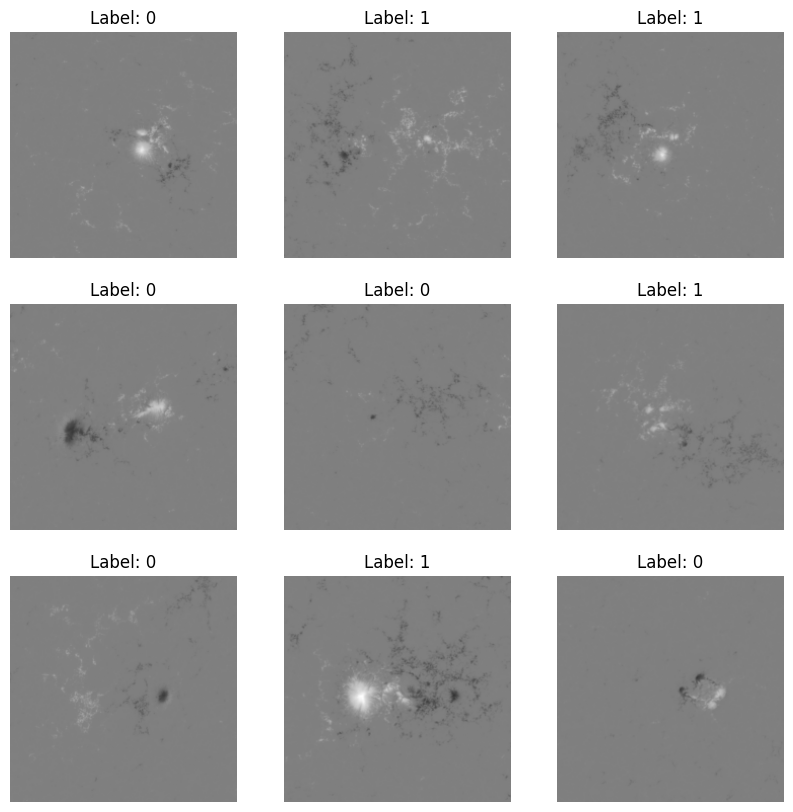

In [9]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break


In [10]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0

    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

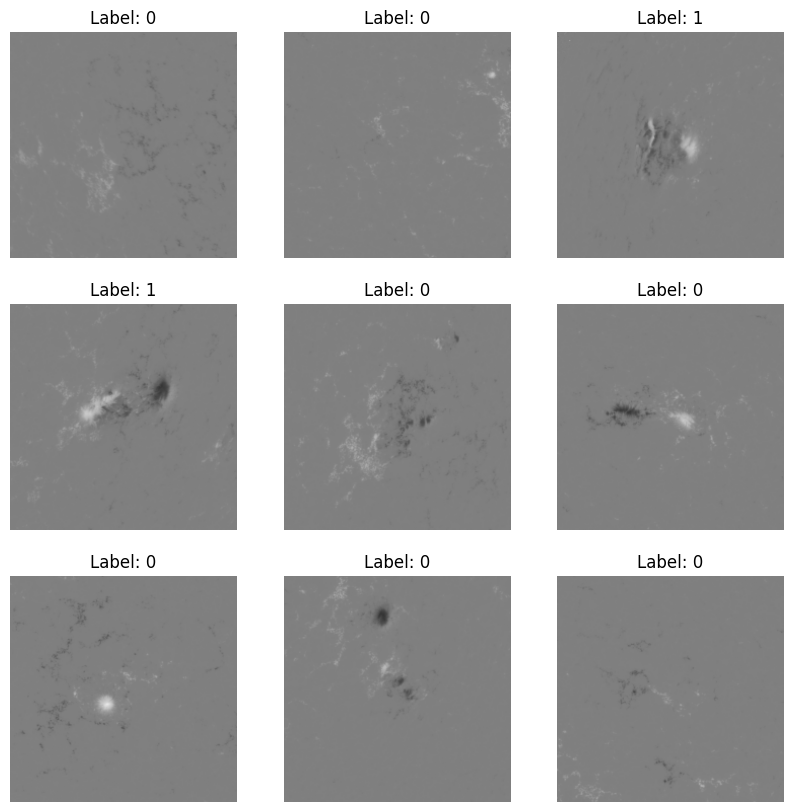

In [11]:
for images, labels in val_dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break

## Final model

In [14]:
import keras

recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

#load model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
for layer in vgg16_model.layers:
    layer.trainable = False

#unfreeze last 2
for layer in vgg16_model.layers[-2:]:
    layer.trainable = True

#create model
inputs = layers.Input(shape=(224, 224, 3))
x = vgg16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 2,360,321 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [16]:
import keras

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile (optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=10),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best_2.keras', save_best_only=True), #saving because google colab can sometimes time out
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd
######################
# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN_2.csv', index=False)

Epoch 1/20
2383/2383 ━━━━━━━━━━━━━━━━━━━━ 688s 281ms/step - accuracy: 0.7254 - loss: 0.5407 - precision: 0.7472 - recall: 0.6725 - val_accuracy: 0.7644 - val_loss: 0.4957 - val_precision: 0.7669 - val_recall: 0.7597 - learning_rate: 1.0000e-04
Epoch 2/20
2383/2383 ━━━━━━━━━━━━━━━━━━━━ 711s 275ms/step - accuracy: 0.7594 - loss: 0.4978 - precision: 0.7789 - recall: 0.7181 - val_accuracy: 0.7648 - val_loss: 0.4858 - val_precision: 0.7790 - val_recall: 0.7394 - learning_rate: 1.0000e-04
Epoch 3/20
2383/2383 ━━━━━━━━━━━━━━━━━━━━ 649s 261ms/step - accuracy: 0.7645 - loss: 0.4906 - precision: 0.7850 - recall: 0.7227 - val_accuracy: 0.7678 - val_loss: 0.4804 - val_precision: 0.7783 - val_recall: 0.7490 - learning_rate: 1.0000e-04
Epoch 4/20
2383/2383 ━━━━━━━━━━━━━━━━━━━━ 617s 259ms/step - accuracy: 0.7672 - loss: 0.4854 - precision: 0.7854 - recall: 0.7295 - val_accuracy: 0.7681 - val_loss: 0.4784 - val_precision: 0.7745 - val_recall: 0.7564 - learning_rate: 1.0000e-04
Epoch 5/20
2383/2383 ━━━

## Results

In [18]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0


    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_test = test['filename'].values
labels_test = test['class'].values

#make the datasets (turns filenames and labels to tensors)
test_dataset = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
test_dataset = test_dataset.map(process_image_and_label_val)

test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
y_pred_prob = model.predict (test_dataset)

3061/3061 ━━━━━━━━━━━━━━━━━━━━ 672s 219ms/step


In [20]:
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred = y_pred.reshape(len(test),)

np.save ('/content/drive/My Drive/Thesis/y_pred_CNN_2.npy', y_pred)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test['class'].values
print (classification_report (y_true, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.76      0.84     77744
           1       0.47      0.81      0.59     20179

    accuracy                           0.77     97923
   macro avg       0.70      0.79      0.72     97923
weighted avg       0.84      0.77      0.79     97923



In [25]:
print ('Mean val accuracy: {}'.format (round (history_df['val_accuracy'].mean(), 2)))
print ('Max val accuracy: {}'.format (round (history_df['val_accuracy'].max(),2)))
print ('SD val accuracy : {}'.format (round (history_df['val_accuracy'].std(),3)))

Mean val accuracy: 0.77
Max val accuracy: 0.78
SD val accuracy : 0.005


In [26]:
import numpy as np

def HSS (confusion_matrix):

    N = confusion_matrix.sum()
    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    E = ((TP + FP)*(TP + FN) + (FN + TN)*(FP + TN)) / N

    HSS = (TP + TN - E) / (N - E)

    return HSS

In [34]:
def TSS (confusion_matrix):

    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    TPR = TP / (TP+FN)
    TNR = TN / (TN+FP)

    TSS = (TPR + TNR) - 1

    return TSS

In [33]:
confusion = confusion_matrix (y_true, y_pred)
print (confusion)

round (HSS (confusion), 2)

[[58967 18777]
 [ 3782 16397]]


0.45

In [35]:
round (TSS (confusion),2)

0.57